# Import

In [1]:
import os
import sys
from datetime import datetime

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
SRC_DIR = os.path.join(ROOT_DIR, 'src')
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import pandas as pd
from IPython.display import display, HTML
from jinja2 import Environment, FileSystemLoader

from config_loader import load_config
from data_loader import load_data
from metrics_calculator import calculate_tables

import matplotlib.pyplot as plt
from io import BytesIO
import base64

# Setup paths

In [2]:
BASE_DIR = '/mnt/c/dev/temp_repos/py-report-sender'
NOTEBOOK_DIR = os.path.join(BASE_DIR, 'notebook')
TEMPLATE_DIR = os.path.join(BASE_DIR, 'templates')
TEMPLATE_FILE = 'report_template_ipynb.html'
CONFIG_PATH = os.path.join(BASE_DIR, 'config.yaml')

sys.path.insert(0, BASE_DIR)
sys.path.insert(0, os.path.join(BASE_DIR, 'src'))
os.chdir(NOTEBOOK_DIR)

# Load Config & Data

In [3]:
# config
config = load_config(CONFIG_PATH)
data_config = config.get('data', {})
report_config = config.get('report', {})
email_config = config.get('email', {})
# data
df = load_data(data_config.get('file_path'))
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head(2))

Data loaded: 308 rows, 11 columns


,id,c_date,campaign_name,category,campaign_id,impressions,mark_spent,clicks,leads,orders,revenue
0,1,2021-02-01,facebook_tier1,social,349043,148263,7307.37,1210,13,1,4981.0
1,2,2021-02-01,facebOOK_tier2,social,348934,220688,16300.20,1640,48,3,14962.0


# Generate Report


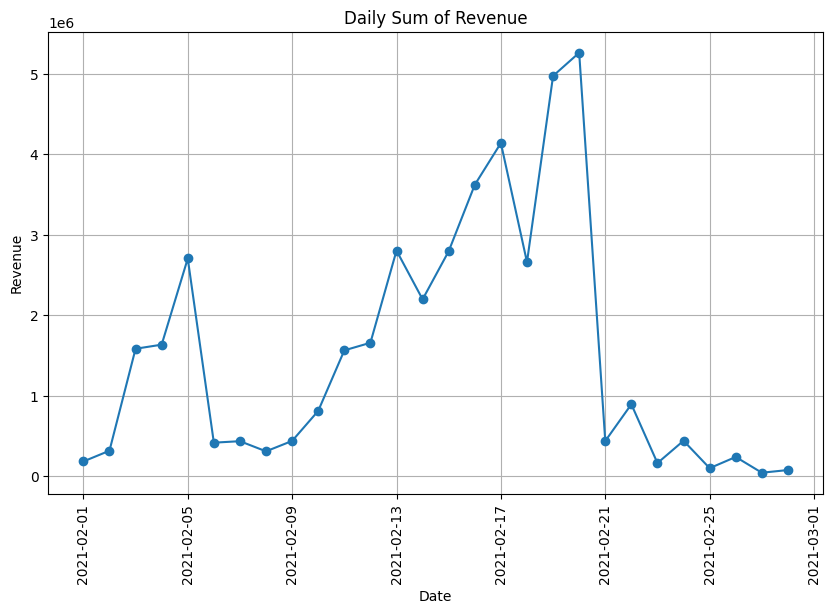
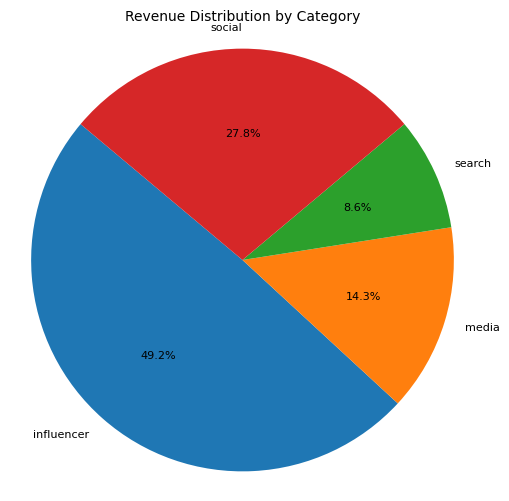

In [4]:
TEMPLATE_DIR = os.path.join(ROOT_DIR, 'templates')
env = Environment(loader=FileSystemLoader(TEMPLATE_DIR))
template = env.get_template(TEMPLATE_FILE)
tables = calculate_tables(df)

def generate_plots_inline(df):
    df['c_date'] = pd.to_datetime(df['c_date'])

    # Plot 1: Daily Revenue
    daily = df.groupby('c_date')['revenue'].sum().reset_index()
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(daily['c_date'], daily['revenue'], marker='o')
    ax1.set_title('Daily Sum of Revenue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Revenue')
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)
    buf1 = BytesIO()
    plt.savefig(buf1, format='png', bbox_inches='tight')
    buf1.seek(0)
    graph1_b64 = base64.b64encode(buf1.read()).decode('utf-8')
    plt.close(fig1)    

    # Plot 2
    revenue_by_category = df.groupby('category')['revenue'].sum()
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    ax2.pie(
        revenue_by_category,
        labels=revenue_by_category.index,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 8}
    )
    ax2.set_title('Revenue Distribution by Category', fontsize=10)
    ax2.axis('equal')
    buf2 = BytesIO()
    plt.savefig(buf2, format='png', bbox_inches='tight')
    buf2.seek(0)
    graph2_b64 = base64.b64encode(buf2.read()).decode('utf-8')
    plt.close(fig2)    

    return (
        f"data:image/png;base64,{graph1_b64}",
        f"data:image/png;base64,{graph2_b64}"
    )


graph1_path, graph2_path = generate_plots_inline(df)

html_report = template.render(
    report_title="Marketing Analytics Report",
    report_period=f"{df['c_date'].min().date()} to {df['c_date'].max().date()}",
    generation_time=datetime.now().strftime('%Y-%m-%d %H:%M'),
    tabla1=tables['table1'],
    tabla2=tables['table2'],
    tabla3=tables['table3'],
    graph1_path=graph1_path,
    graph2_path=graph2_path
)

from IPython.display import HTML, display
display(HTML(html_report))
